In [1]:
import gym
import gym_example
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Adversary example: shortest path between agent and goal

This notebook trains the adversary to create the shortest path possible between agent and goal. Only one wall is used. Grid size 38x38 in adversarial-v2 reward is set to: self.reward = - (self.shortest_path_length - 25)
            

## Checking that everything works

In [3]:
env = gym.make("adversarial-v2")

In [3]:
def visualize(state):
    fig = plt.imshow(state, cmap=plt.get_cmap('Accent'))
    # values
    values = np.array([0, 1, 2, 3])
    #items
    items = ['Arena', 'Agent', 'Goal', 'Wall']
    # colormap used by imshow
    colors = [fig.cmap(fig.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.grid(False)
    plt.show()

In [4]:
def run_one_episode(env, verbose=False):
    env.reset()
    sum_reward = 0

    for i in range(env.MAX_STEPS+1):
        action = env.action_space.sample()
        if verbose:
            print("action:", action)
        state, reward, done, info = env.step(action)
        sum_reward += reward

        if verbose:
            env.render()

        if done:
            if verbose:
                print("done @ step {}".format(i))
            break

    if verbose:
        print("cumulative reward", sum_reward)

    return sum_reward

Sum reward:  -28


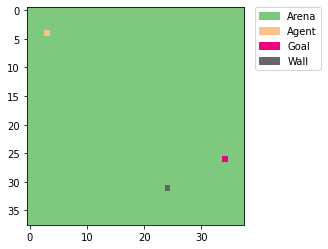

In [5]:
env = gym.make("adversarial-v2")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

#visualize(env.state) --> if adversarial_v0

visualize(env.image_space) 

In [6]:
env = gym.make("adversarial-v2")
env.step(0)
env.step(0)

({'image': array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'time_step': [2]},
 0,
 False,
 {})

In [7]:
history = []

for _ in range(20):
    sum_reward = run_one_episode(env, verbose=False)
    history.append(sum_reward)

avg_sum_reward = sum(history) / len(history)
print("\nbaseline cumulative reward: {:6.2}".format(avg_sum_reward))


baseline cumulative reward:   -2.8


In [8]:
history

[7, -23, 4, -34, 1, 16, -26, 3, 9, 9, -1, 4, -11, -11, 21, -22, 3, -14, 4, 5]

In [9]:
env.image_space.shape

(38, 38)

# Train

Initialize the directory in which to save checkpoints (i.e., serialize a policy to disk) as a subdirectory ./tmp/exa and also the directory in which to write the logs which Ray expects to be at ~/ray_results/ by default:

In [10]:
import os
import shutil

chkpt_root = "tmp/exa"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

We’ll start Ray running in local mode, i.e., not running on a remote cluster:

In [7]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

2021-04-07 14:21:16,963	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.24',
 'raylet_ip_address': '192.168.1.24',
 'redis_address': '192.168.1.24:6379',
 'object_store_address': '/tmp/ray/session_2021-04-07_14-21-16_373624_3854/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-07_14-21-16_373624_3854/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-07_14-21-16_373624_3854',
 'metrics_export_port': 61960,
 'node_id': 'b33747cb25cc6cbdce48fad30837b1b1775b0a0dc560f30dbb234e53'}

Register our environment

In [8]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v2 import Adversarial_v2

select_env = "adversarial-v2"
register_env(select_env, lambda config: Adversarial_v2())

Next we’ll configure the environment to use proximal policy optimization (PPO) and create an agent to train using RLlib:

In [9]:
import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

2021-04-07 14:21:21,256	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-07 14:21:24,529	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-07 14:21:27,061	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-07 14:21:34,276	INFO trainable.py:103 -- Trainable.setup took 13.327 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-04-07 14:21:34,278	WARNING util.py:47 -- Install gputil for GPU system monitoring.


In [14]:
ppo.DEFAULT_CONFIG

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 4000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'num_framestacks': 'auto',
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_actio

For each iteration, we call result = agent.train() to run the episodes, and then call chkpt_file = agent.save(chkpt_root) to save a checkpoint of the latest policy. Then we print metrics that show how well the learning has progressed. The resulting output should look close to the following:

In [15]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 100
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))

 1 reward -43.00/ -0.70/ 24.00 len 4.00 saved tmp/exa/checkpoint_1/checkpoint-1
 2 reward -43.00/ -0.14/ 24.00 len 4.00 saved tmp/exa/checkpoint_2/checkpoint-2
 3 reward -39.00/ -0.07/ 24.00 len 4.00 saved tmp/exa/checkpoint_3/checkpoint-3
 4 reward -42.00/  0.98/ 24.00 len 4.00 saved tmp/exa/checkpoint_4/checkpoint-4
 5 reward -31.00/  1.90/ 24.00 len 4.00 saved tmp/exa/checkpoint_5/checkpoint-5
 6 reward -33.00/  2.21/ 24.00 len 4.00 saved tmp/exa/checkpoint_6/checkpoint-6
 7 reward -40.00/  3.32/ 24.00 len 4.00 saved tmp/exa/checkpoint_7/checkpoint-7
 8 reward -34.00/  4.11/ 24.00 len 4.00 saved tmp/exa/checkpoint_8/checkpoint-8
 9 reward -31.00/  4.23/ 24.00 len 4.00 saved tmp/exa/checkpoint_9/checkpoint-9
10 reward -36.00/  5.77/ 24.00 len 4.00 saved tmp/exa/checkpoint_10/checkpoint-10
11 reward -31.00/  6.37/ 24.00 len 4.00 saved tmp/exa/checkpoint_11/checkpoint-11
12 reward -33.00/  7.61/ 24.00 len 4.00 saved tmp/exa/checkpoint_12/checkpoint-12
13 reward -30.00/  7.63/ 24.00 len

RayTaskError: [36mray::RolloutWorker.par_iter_next()[39m (pid=3487, ip=127.0.1.1)
  File "python/ray/_raylet.pyx", line 432, in ray._raylet.execute_task.function_executor
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/util/iter.py", line 1152, in par_iter_next
    return next(self.local_it)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 327, in gen_rollouts
    yield self.sample()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 662, in sample
    batches = [self.input_reader.next()]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 95, in next
    batches = [self.get_data()]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 224, in get_data
    item = next(self.rollout_provider)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 656, in _env_runner
    tf_sess=tf_sess,
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 1344, in _do_policy_eval_w_trajectory_view_api
    episodes=[active_episodes[t.env_id] for t in eval_data])
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/policy/tf_policy.py", line 367, in compute_actions_from_input_dict
    fetched = builder.get(to_fetch)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/utils/tf_run_builder.py", line 44, in get
    self.feed_dict, os.environ.get("TF_TIMELINE_DIR"))
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/utils/tf_run_builder.py", line 89, in run_timeline
    fetches = sess.run(ops, feed_dict=feed_dict)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 956, in run
    run_metadata_ptr)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1165, in _run
    self._graph, fetches, feed_dict_tensor, feed_handles=feed_handles)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 474, in __init__
    self._fetch_mapper = _FetchMapper.for_fetch(fetches)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 266, in for_fetch
    return _ListFetchMapper(fetch)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 375, in __init__
    self._mappers = [_FetchMapper.for_fetch(fetch) for fetch in fetches]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 375, in <listcomp>
    self._mappers = [_FetchMapper.for_fetch(fetch) for fetch in fetches]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 268, in for_fetch
    return _DictFetchMapper(fetch)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 410, in __init__
    self._unique_fetches, self._value_indices = _uniquify_fetches(self._mappers)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 360, in _uniquify_fetches
    m_value_indices.append(j)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

[36mray::RolloutWorker.par_iter_next()[39m (pid=3487, ip=127.0.1.1)
  File "python/ray/_raylet.pyx", line 473, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 497, in ray._raylet.execute_task
ray.exceptions.TaskCancelledError: Task: TaskID(ffffffffffffffffffffffffffffffffffffffff01000000) was cancelled

In [ ]:
tensorboard --logdir=$HOME/ray_results

# Apply a trained policy in a rollout

In [10]:
chkpt_root = "tmp/exa"
chkpt_file = chkpt_root + '/checkpoint_35/checkpoint-35'

#restore the latest saved checkpoint for the policy
agent.restore(chkpt_file)
#create our environment 
env = gym.make(select_env)
#reset its state
state = env.reset()

2021-04-07 14:21:34,861	INFO trainable.py:372 -- Restored on 192.168.1.24 from checkpoint: tmp/exa/checkpoint_35/checkpoint-35
2021-04-07 14:21:34,862	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 35, '_timesteps_total': None, '_time_total': 1719.7399272918701, '_episodes_total': 35000}


cumulative reward 22


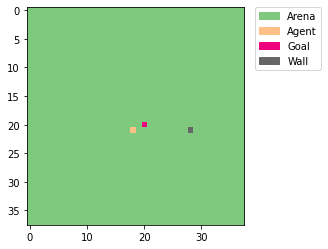

cumulative reward 24


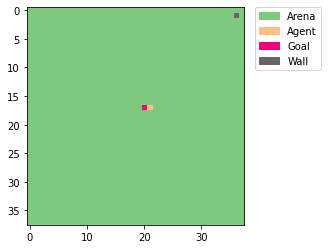

cumulative reward 19


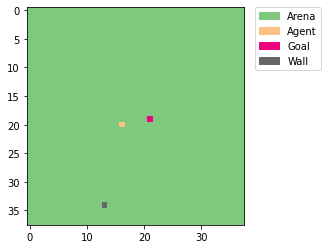

cumulative reward 22


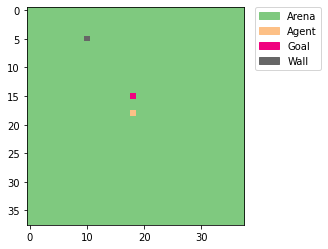

cumulative reward 22


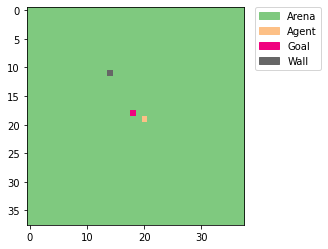

cumulative reward 23


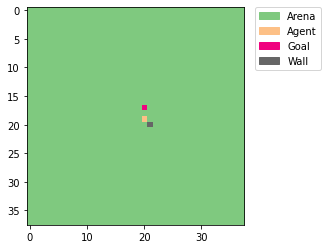

cumulative reward 23


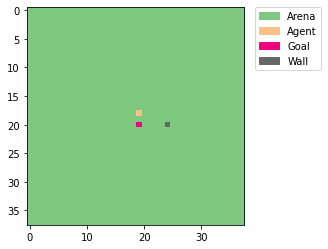

cumulative reward 24


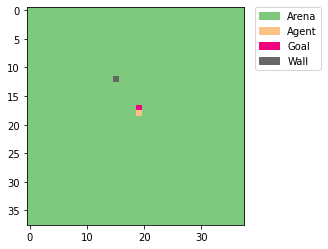

cumulative reward 24


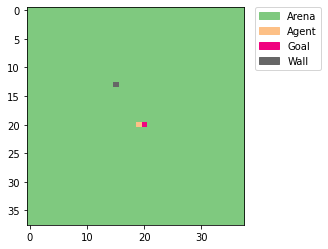

cumulative reward 24


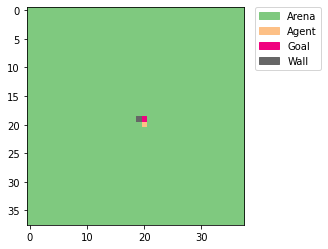

cumulative reward 23


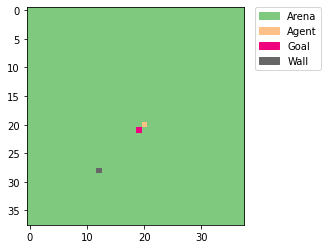

cumulative reward 21


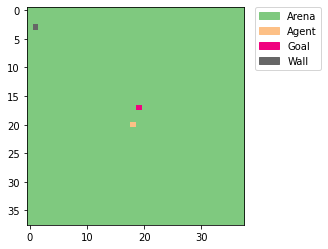

cumulative reward 20


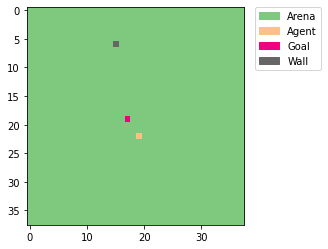

cumulative reward 23


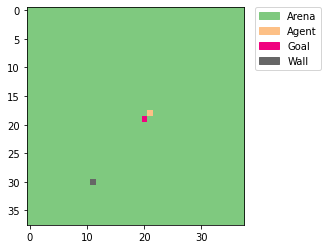

cumulative reward 21


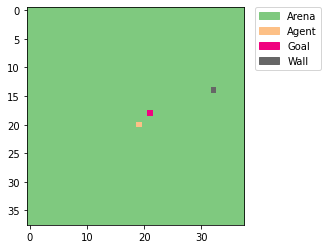

cumulative reward 21


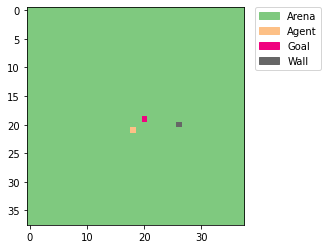

cumulative reward 18


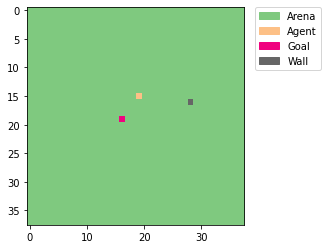

cumulative reward 9


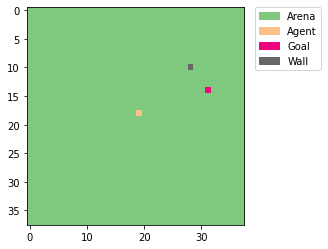

cumulative reward 22


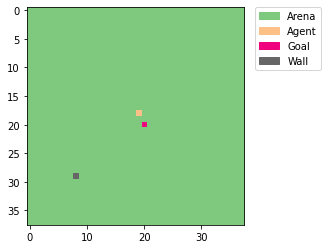

cumulative reward 23


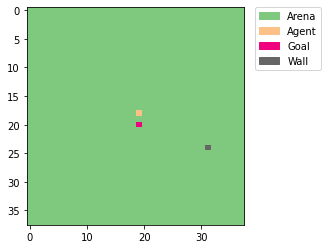

cumulative reward 24


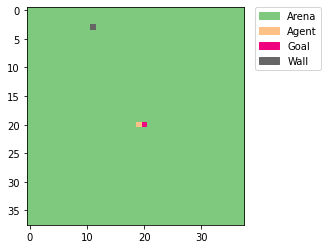

cumulative reward 24


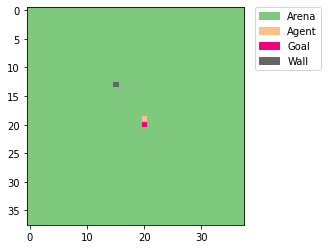

cumulative reward 21


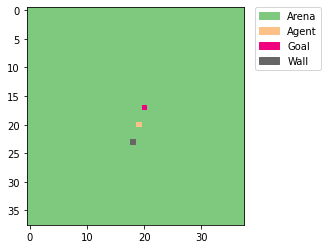

cumulative reward 23


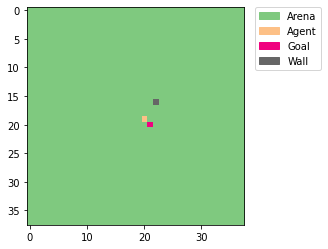

cumulative reward 23


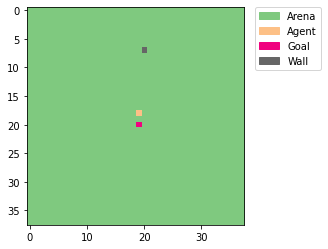

In [18]:
# Visualize some of the environments created
sum_reward = 0
n_step = 10
for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)    
    sum_reward += reward
    #env.render()    
    if done == True:
        print("cumulative reward", sum_reward)
        visualize(env.image_space) 
        state = env.reset()
        sum_reward = 0

# Create environment

In [11]:
from utils import *
import gym

In [20]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v2 import Adversarial_v2

select_env = "adversarial-v2"
register_env(select_env, lambda config: Adversarial_v2())

In [21]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

2021-04-05 10:42:28,481	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
2021-04-05 10:42:28,572	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-05 10:42:29,445	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-05 10:42:30,286	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-05 10:42:32,999	WARNING util.py:47 -- Install gputil for GPU system monitoring.


In [20]:
config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 4000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'num_framestacks': 'auto',
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_actio

In [14]:
chkpt_root = "tmp/exa"
chkpt_file = chkpt_root + '/checkpoint_35/checkpoint-35'

#restore the latest saved checkpoint for the policy
agent.restore(chkpt_file)
#create our environment 
env = gym.make(select_env)
#reset its state
state = env.reset()

sum_reward = 0
n_step = 3
for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)    
    sum_reward += reward
    #env.render()    
    if done == True:
        print("cumulative reward", sum_reward)
        visualize(env.image_space) 
        state = env.reset()
        sum_reward = 0

2021-04-07 14:21:59,062	INFO trainable.py:372 -- Restored on 192.168.1.24 from checkpoint: tmp/exa/checkpoint_35/checkpoint-35
2021-04-07 14:21:59,064	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 35, '_timesteps_total': None, '_time_total': 1719.7399272918701, '_episodes_total': 35000}


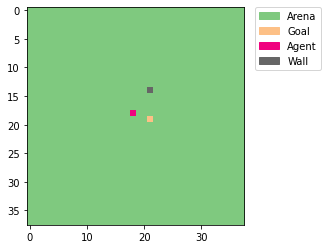

In [15]:
visualize(env.image_space) 

In [16]:
# padd with zeroes

matrix = np.zeros((40, 40))
# actually you can also use result = np.zeros_like(b) 
# but that also copies the dtype not only the shape

matrix[1:39,1:39] = env.image_space
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
my_config = matrix2arena(matrix)
#my_config.to_proto()

In [18]:
# visualize evironment just created

try:
    environment = AnimalAIEnvironment(
            file_name='../env/AnimalAI',
            base_port=5007,
            arenas_configurations=my_config,
            play=True,
            worker_id = 5,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

In [19]:
if environment:
    environment.close() # takes a few seconds